# Import files

In [1]:
from Strats.PairTradingStrat import *
from PnL_Metrics.PortfolioMetrics import *
from PnL_Metrics.WRC import *
from PnL_Metrics.Backtest import *

import warnings

warnings.filterwarnings("ignore")

# Run Strats

In [2]:
# Get all available tickers
response = requests.get(f"{BASE_URL}/ticker/price")
data = response.json()
BTC_pairs = [i["symbol"] for i in data if "BTC" in i["symbol"]]


In [ ]:
coint_pairs = get_coint_pairs(BTC_pairs, interval = '5m', start_date="2024-01-01", end_date="2024-01-31")
len(coint_pairs)

100%|██████████| 524/524 [16:11<00:00,  1.85s/it]


62

In [3]:
# test_pairs = coint_pairs[:4]
test_pairs = ['BTCUSDT', 'BNBUSDT']
print(test_pairs)

symbol_manager = BinanceSymbolManager()
# Add symbols
for t in test_pairs:
    print(symbol_manager.add_symbol(t))  # Success

price_fetcher = BinancePriceFetcher(symbol_manager.get_symbols())
# Fetch pair historical price
pair_portfolio = price_fetcher.get_grp_historical_ohlcv(
        interval="5m",
        start_date="2024-06-01",
        end_date="2024-12-31"
    )

pair_portfolio

['BTCUSDT', 'BNBUSDT']
'BTCUSDT' added successfully.
'BNBUSDT' added successfully.


,timestamp,BNBUSDT,BTCUSDT
0,2024-06-01 00:00:00,594.20,67647.88
1,2024-06-01 00:05:00,593.90,67614.21
2,2024-06-01 00:10:00,593.90,67586.61
3,2024-06-01 00:15:00,593.40,67529.45
4,2024-06-01 00:20:00,593.30,67511.97
...,...,...,...
61340,2024-12-30 23:40:00,703.29,92756.49
61341,2024-12-30 23:45:00,704.04,92725.99
61342,2024-12-30 23:50:00,705.41,92789.83
61343,2024-12-30 23:55:00,705.36,92792.05


In [11]:
model = pair_trading(pair_portfolio.copy())
spread = model.generate_signals(lookback=8640, execute_threshold=1.5, close_threshold=0.7)
spread

,timestamp,BNBUSDT,BTCUSDT,BNBUSDT_rolling_mean,BNBUSDT_rolling_std,BNBUSDT_z_scores,BNBUSDT_is_mean_revert,BNBUSDT_signal,BNBUSDT_exit_signal,BTCUSDT_rolling_mean,BTCUSDT_rolling_std,BTCUSDT_z_scores,BTCUSDT_is_mean_revert,BTCUSDT_signal,BTCUSDT_exit_signal
0,2024-06-01 00:00:00,594.20,67647.88,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0
1,2024-06-01 00:05:00,593.90,67614.21,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0
2,2024-06-01 00:10:00,593.90,67586.61,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0
3,2024-06-01 00:15:00,593.40,67529.45,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0
4,2024-06-01 00:20:00,593.30,67511.97,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61340,2024-12-30 23:40:00,703.29,92756.49,700.806693,29.254567,0.084886,0,0,1,98496.242708,3396.763758,-1.689771,1,1,0
61341,2024-12-30 23:45:00,704.04,92725.99,700.812418,29.250359,0.110343,0,0,1,98495.811920,3397.259535,-1.698375,1,1,0
61342,2024-12-30 23:50:00,705.41,92789.83,700.818333,29.246119,0.157001,0,0,1,98495.388394,3397.742783,-1.679220,1,1,0
61343,2024-12-30 23:55:00,705.36,92792.05,700.824344,29.241715,0.155109,0,0,1,98494.969882,3398.222585,-1.678207,1,1,0


In [140]:
pair_backtest = Backtest(spread.copy(), tickers = test_pairs, test_start_date="2024-07-01", test_end_date="2024-12-31", stoploss=0.05, drawdown_duration=5000)
pair_pnl_df = pair_backtest.computePortfolioPnL()
pair_pnl_df

,timestamp,total_daily_pnl,total_pnl
0,2024-07-01 00:00:00,0.000000,0.000000
1,2024-07-01 00:05:00,0.000000,0.000000
2,2024-07-01 00:10:00,0.000000,0.000000
3,2024-07-01 00:15:00,0.000000,0.000000
4,2024-07-01 00:20:00,0.000000,0.000000
...,...,...,...
52700,2024-12-30 23:40:00,1039.217144,97762.071996
52701,2024-12-30 23:45:00,841.685230,97564.540081
52702,2024-12-30 23:50:00,1271.044385,97993.899236
52703,2024-12-30 23:55:00,1286.528097,98009.382948


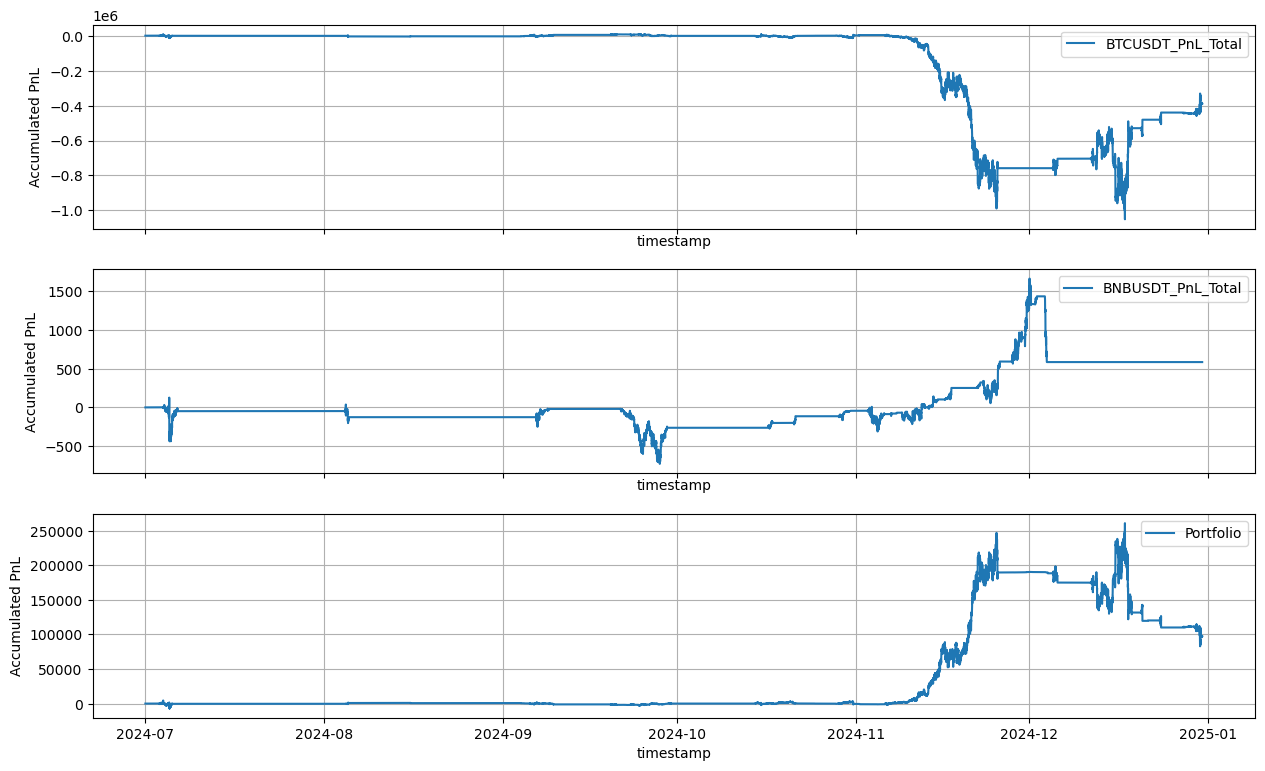

In [141]:
pair_backtest.plot_pnl()

In [130]:
# Fetch pair historical price
pair_portfolio_momentum = pair_portfolio[pair_portfolio["timestamp"] >= "2024-07-01"].reset_index(drop=True)


# Initialize strategy
momentum = MomentumStrat(data=pair_portfolio_momentum)

momentum_df = momentum.momentum_strategy(lookback=30, hold_period=10)
momentum_df

,timestamp,BNBUSDT,BTCUSDT,BNBUSDT_signal,BNBUSDT_exit_signal,BTCUSDT_signal,BTCUSDT_exit_signal
0,2024-07-01 00:00:00,582.00,62722.08,NaN,NaN,NaN,NaN
1,2024-07-01 00:05:00,580.60,62648.49,NaN,NaN,NaN,NaN
2,2024-07-01 00:10:00,580.40,62624.00,NaN,NaN,NaN,NaN
3,2024-07-01 00:15:00,581.00,62682.02,NaN,NaN,NaN,NaN
4,2024-07-01 00:20:00,581.30,62674.01,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
52700,2024-12-30 23:40:00,703.29,92756.49,0.0,0.0,0.0,0.0
52701,2024-12-30 23:45:00,704.04,92725.99,0.0,0.0,0.0,0.0
52702,2024-12-30 23:50:00,705.41,92789.83,0.0,0.0,0.0,0.0
52703,2024-12-30 23:55:00,705.36,92792.05,0.0,0.0,0.0,0.0


In [131]:
momentum_backtest = Backtest(momentum_df.copy(), tickers = test_pairs, test_start_date="2024-07-01", test_end_date="2024-12-31", stoploss=0.1, drawdown_duration=100)
momentum_pnl_df = momentum_backtest.computePortfolioPnL()
momentum_pnl_df

,timestamp,total_daily_pnl,total_pnl
0,2024-07-01 00:00:00,0.0,0.0
1,2024-07-01 00:05:00,NaN,NaN
2,2024-07-01 00:10:00,NaN,NaN
3,2024-07-01 00:15:00,NaN,NaN
4,2024-07-01 00:20:00,NaN,NaN
...,...,...,...
52700,2024-12-30 23:40:00,NaN,NaN
52701,2024-12-30 23:45:00,NaN,NaN
52702,2024-12-30 23:50:00,NaN,NaN
52703,2024-12-30 23:55:00,NaN,NaN


# Comparison

In [142]:
pair_returns = pair_backtest.get_returns(notional = 10e6)
# momentum_returns = momentum_backtest.get_returns(notional = 10e6)

returns = pd.DataFrame()
# returns["Momentum"] = momentum_returns
returns["Pair_Trade"] = pair_returns

port_metrics = PortfolioMetrics(returns.dropna(), periods_per_year=252*12*24)
summary = port_metrics.summary(risk_free_rate=0)
print(summary)

            Annualized Return  Annualized Volatility  Sharpe Ratio  \
Pair_Trade           0.013358               0.020823      0.647682   

            Max Drawdown Duration  Max Drawdown  Calmar Ratio  Skewness  \
Pair_Trade                  37259     -0.017665      0.756191 -0.561828   

              Kurtosis  VaR (5%)  CVaR (5%)  Tail Ratio  Omega Ratio  
Pair_Trade  119.209254 -0.000024  -0.000161    1.038968     1.021653  


In [28]:
wrc = WhiteRealityCheck(strategies=returns["Pair_Trade"], benchmark=returns["Momentum"])
wrc.run()
wrc.superior_strategies()

White Reality Check Results:
p-value: lower         0.097
consistent    0.097
upper         0.097
dtype: float64
Superior strategy indices:
[]


[]